In [ ]:
import sys
!{sys.executable} -m pip install beautifulsoup4 lxml html5lib

In [ ]:
import csv
from bs4 import BeautifulSoup
import requests
from selenium import webdriver
import time

skip_list = ['…','！','？','「','」','。', '，', '、', '：', '“', '”', "《", "》", '\n','；','— —','（', '）']
skip_str = "".join(str(e) for e in skip_list)

headers = {
    'accept': '*/*',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.9',
    'referer': 'https://www.google.com',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36 Edg/85.0.564.44'
}

def get_article(card):
    """Extract article information from the raw html"""
    raw_link = card.get('href')
    response = requests.get(raw_link, headers=headers)
    soup = BeautifulSoup(response.text, 'html.parser')
    article_body = soup.find('div', 'article_body')
    if article_body:
        article_body = soup.find('div', 'article_body').text.replace('\n', ' ').strip()
        return [article_body]

def get_the_news(url):
    """Run the main program"""
    driver = webdriver.Chrome('./chromedriver') 
    driver.get(url) 
    time.sleep(5) 
    html = driver.page_source
    soup = BeautifulSoup(html, 'html.parser')
    cards = soup.find_all('a', 'newsFeed_item_link')
    # extract articles from page
    articles = []
    for card in cards[:50]:
        article = get_article(card)
        articles.append(article)
        with open('news.csv', 'a', newline='', encoding='utf-8') as f:
            writer = csv.writer(f)
            writer.writerows(articles)
        articles = []  
     

# run the main program
get_the_news('https://news.yahoo.co.jp/categories/business')
get_the_news('https://news.yahoo.co.jp/categories/sports')
get_the_news('https://news.yahoo.co.jp/categories/it')
get_the_news('https://news.yahoo.co.jp/categories/science')


In [1]:
import jieba

with open('news.csv') as f:
    japanese_text = f.read()
    japanese_text = japanese_text.split()
print(len(japanese_text))
texts = []
for sentence in japanese_text:
    texts.append(jieba.cut(sentence))
texts = [[word for word in text if len(word)>1] for text in texts]
with open('thesaurus.txt', 'w') as filehandle:
    for listitem in texts:
        filehandle.write("\n".join(map(lambda x: str(x), listitem)))

Building prefix dict from the default dictionary ...
Loading model from cache /tmp/jieba.cache


2355


Loading model cost 1.099 seconds.
Prefix dict has been built successfully.


In [2]:
with open('thesaurus.txt', 'r') as f:
    words = [line.rstrip('\n') for line in f]

words[1:10]

['装着', '追加', '車種', 'GR86', 'ZN8', 'BRZ', 'ZD8', '追加', '28']

In [4]:
from collections import Counter

def create_lookup_tables(words):
    """
    Create lookup tables for vocabulary
    :param words: Input list of words
    :return: Two dictionaries, vocab_to_int, int_to_vocab
    """
    word_counts = Counter(words)
    # sorting the words from most to least frequent in text occurrence
    sorted_vocab = sorted(word_counts, key=word_counts.get, reverse=True)
    # create int_to_vocab dictionaries
    int_to_vocab = {ii: word for ii, word in enumerate(sorted_vocab)}
    vocab_to_int = {word: ii for ii, word in int_to_vocab.items()}

    return vocab_to_int, int_to_vocab

# words = preprocess(text)
vocab_to_int, int_to_vocab = create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]
# print some stats about this word data
print("Total words in text: {}".format(len(words)))
print("Unique words: {}".format(len(set(words)))) # `set` removes any duplicate words

Total words in text: 10524
Unique words: 4462


In [5]:
from collections import Counter
import random
import numpy as np

threshold = 1e-5
word_counts = Counter(int_words)
#print(list(word_counts.items())[0])  # dictionary of int_words, how many times they appear

total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
# discard some frequent words, according to the subsampling equation
# create a new list of words for training
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

print(train_words[:30])

[1531, 935, 936, 934, 1535, 1536, 1538, 164, 1541, 937, 44, 1543, 164, 119, 1545, 295, 1546, 1549, 1552, 1557, 1558, 479, 1562, 360, 1568, 1569, 1574, 1578, 1582, 1584]


In [6]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = words[start:idx] + words[idx+1:stop+1]
    
    return list(target_words)

In [7]:
# run this cell multiple times to check for random window selection
int_text = [i for i in range(10)]
print('Input: ', int_text)
idx=5 # word index of interest

target = get_target(int_text, idx=idx, window_size=5)
print('Target: ', target)  # you should get some indices around the idx

Input:  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Target:  [1, 2, 3, 4, 6, 7, 8, 9]


In [8]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    n_batches = len(words)//batch_size
    # only full batches
    words = words[:n_batches*batch_size]
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y

In [9]:
int_text = [i for i in range(20)]
x,y = next(get_batches(int_text, batch_size=4, window_size=5))

print('x\n', x)
print('y\n', y)

x
 [0, 0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3]
y
 [1, 2, 3, 0, 2, 3, 0, 1, 3, 0, 1, 2]


In [10]:
def cosine_similarity(embedding, valid_size=16, valid_window=100, device='cpu'):
    """ Returns the cosine similarity of validation words with words in the embedding matrix.
        Here, embedding should be a PyTorch embedding module.
    """
    
    # Here we're calculating the cosine similarity between some random words and 
    # our embedding vectors. With the similarities, we can look at what words are
    # close to our random words.
    
    # sim = (a . b) / |a||b|
    
    embed_vectors = embedding.weight
    
    # magnitude of embedding vectors, |b|
    magnitudes = embed_vectors.pow(2).sum(dim=1).sqrt().unsqueeze(0)
    
    # pick N words from our ranges (0,window) and (1000,1000+window). lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples,
                               random.sample(range(1000,1000+valid_window), valid_size//2))
    valid_examples = torch.LongTensor(valid_examples).to(device)
    
    valid_vectors = embedding(valid_examples)
    similarities = torch.mm(valid_vectors, embed_vectors.t())/magnitudes
        
    return valid_examples, similarities

In [11]:
import torch
from torch import nn
import torch.optim as optim

In [12]:
class SkipGram(nn.Module):
    def __init__(self, n_vocab, n_embed):
        super().__init__()
        
        self.embed = nn.Embedding(n_vocab, n_embed)
        self.output = nn.Linear(n_embed, n_vocab)
        self.log_softmax = nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        x = self.embed(x)
        scores = self.output(x)
        log_ps = self.log_softmax(scores)
        
        return log_ps

In [13]:
# check if GPU is available
CUDA_LAUNCH_BLOCKING=1.
device = 'cuda' if torch.cuda.is_available() else 'cpu'

embedding_dim=300 # you can change, if you want

model = SkipGram(len(vocab_to_int), embedding_dim).to(device)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

print_every = 50
steps = 0
epochs = 100

# train for some number of epochs
for e in range(epochs):
    
    # get input and target batches
    for inputs, targets in get_batches(train_words, 512):
        steps += 1
        inputs, targets = torch.LongTensor(inputs), torch.LongTensor(targets)
        inputs, targets = inputs.to(device), targets.to(device)
        
        log_ps = model(inputs)
        loss = criterion(log_ps, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if steps % print_every == 0:                  
            # getting examples and similarities      
            valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
            _, closest_idxs = valid_similarities.topk(6) # topk highest similarities
            
            valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
            for ii, valid_idx in enumerate(valid_examples):
                closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
                print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
            print("...")

米国 | 入社, 病院, 瞬間, 織機, 一概一般
可能性 | 展示会, 電器, 参入, 70詳細, 完全
高校 | 日米, 新聞社獲得USATODAYSports通算, 陛下, 雪解, 会見
配信 | 少子, 6699, 先名, 試合, 開始日本
出場 | Home, StarrCapital, 望生左翼, 記念, 当該
2022 | 法令, 2.90, MSD, 語手, X2700H
番号 | 純一札幌, 不明LRO, 点差, 大容量, DH
提供 | 定番, 改善研究成果, 中心提案, 定義, 銀座仕事
格納庫 | S21630HT, 出品, 素敵玉西武, 疑問, 依存性
高所作業 | 現地, 伊丹, 比例, 意義, 助演
年末 | SalesforceServiceCloud, 大径, 興行, 突然, 居振
PIXTA | 情報, 一面残念大切, 酒類, 円山, 10Pro
合成 | 2W101有機, 事長, 印象, 2W101, 三重
外装 | 配信海外2022AmazonOriginal住民11時半, P5TCTS, 直感, GoogleTakeout, FA
直前 | 分間材料, 名付, 思惑, 水準, 負担
737 | 2020桑原今年境地閉幕, AV, 新聞社獲得USATODAYSports通算, 短時間, 魔法11至上
...
番号 | 純一札幌, 不明LRO, 点差, 大容量, DH
世界 | 知識SO, 配信編, 最近SNS, 影響好感度, 削除
必要 | 義務付, 高橋, 大手, 各種EU, 根尾
衝突 | 出場動画, J2, 独占, 更新, 編集商品
2022 | 法令, 2.90, 語手, 大阪府, X2700H
作業 | 未定14, 連合, 64GB, 目的, 進行
代表 | 組合員, 業種, 必要作業, 語版, 助演
人工 | 子東, 飛距, 日生, 29m, 陰影
地面画像 | 目指Mellow, 一審, 波及, 翌年, 大切
累計 | 連絡, 作井春愛, 262022, NHKTennisClassic集部LAFC, 原作者
富裕 | 辻村, 1.6, 施策, SalesforceFinancialServicesCloud, 15kg
個性 | 化球, 文字, 出典, 編集IT, 店内
客室 | 固定, 本市, 介氏, 先進,

In [14]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [15]:
# getting embeddings from the embedding layer of our model, by name
embeddings = model.embed.weight.to('cpu').data.numpy()
torch.save(model.state_dict(), 'model.pt')

In [16]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

Model's state_dict:
embed.weight 	 torch.Size([4462, 300])
output.weight 	 torch.Size([4462, 300])
output.bias 	 torch.Size([4462])


In [17]:
model =SkipGram(len(vocab_to_int), embedding_dim).to(device)
model.load_state_dict(torch.load('model.pt'))
embeddings = model.embed.weight.to('cpu').data.numpy()

In [18]:
viz_words = 600
tsne = TSNE()
embed_tsne = tsne.fit_transform(embeddings[:viz_words, :])

/home/julkarnine/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/julkarnine/miniconda3/envs/pytorch/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


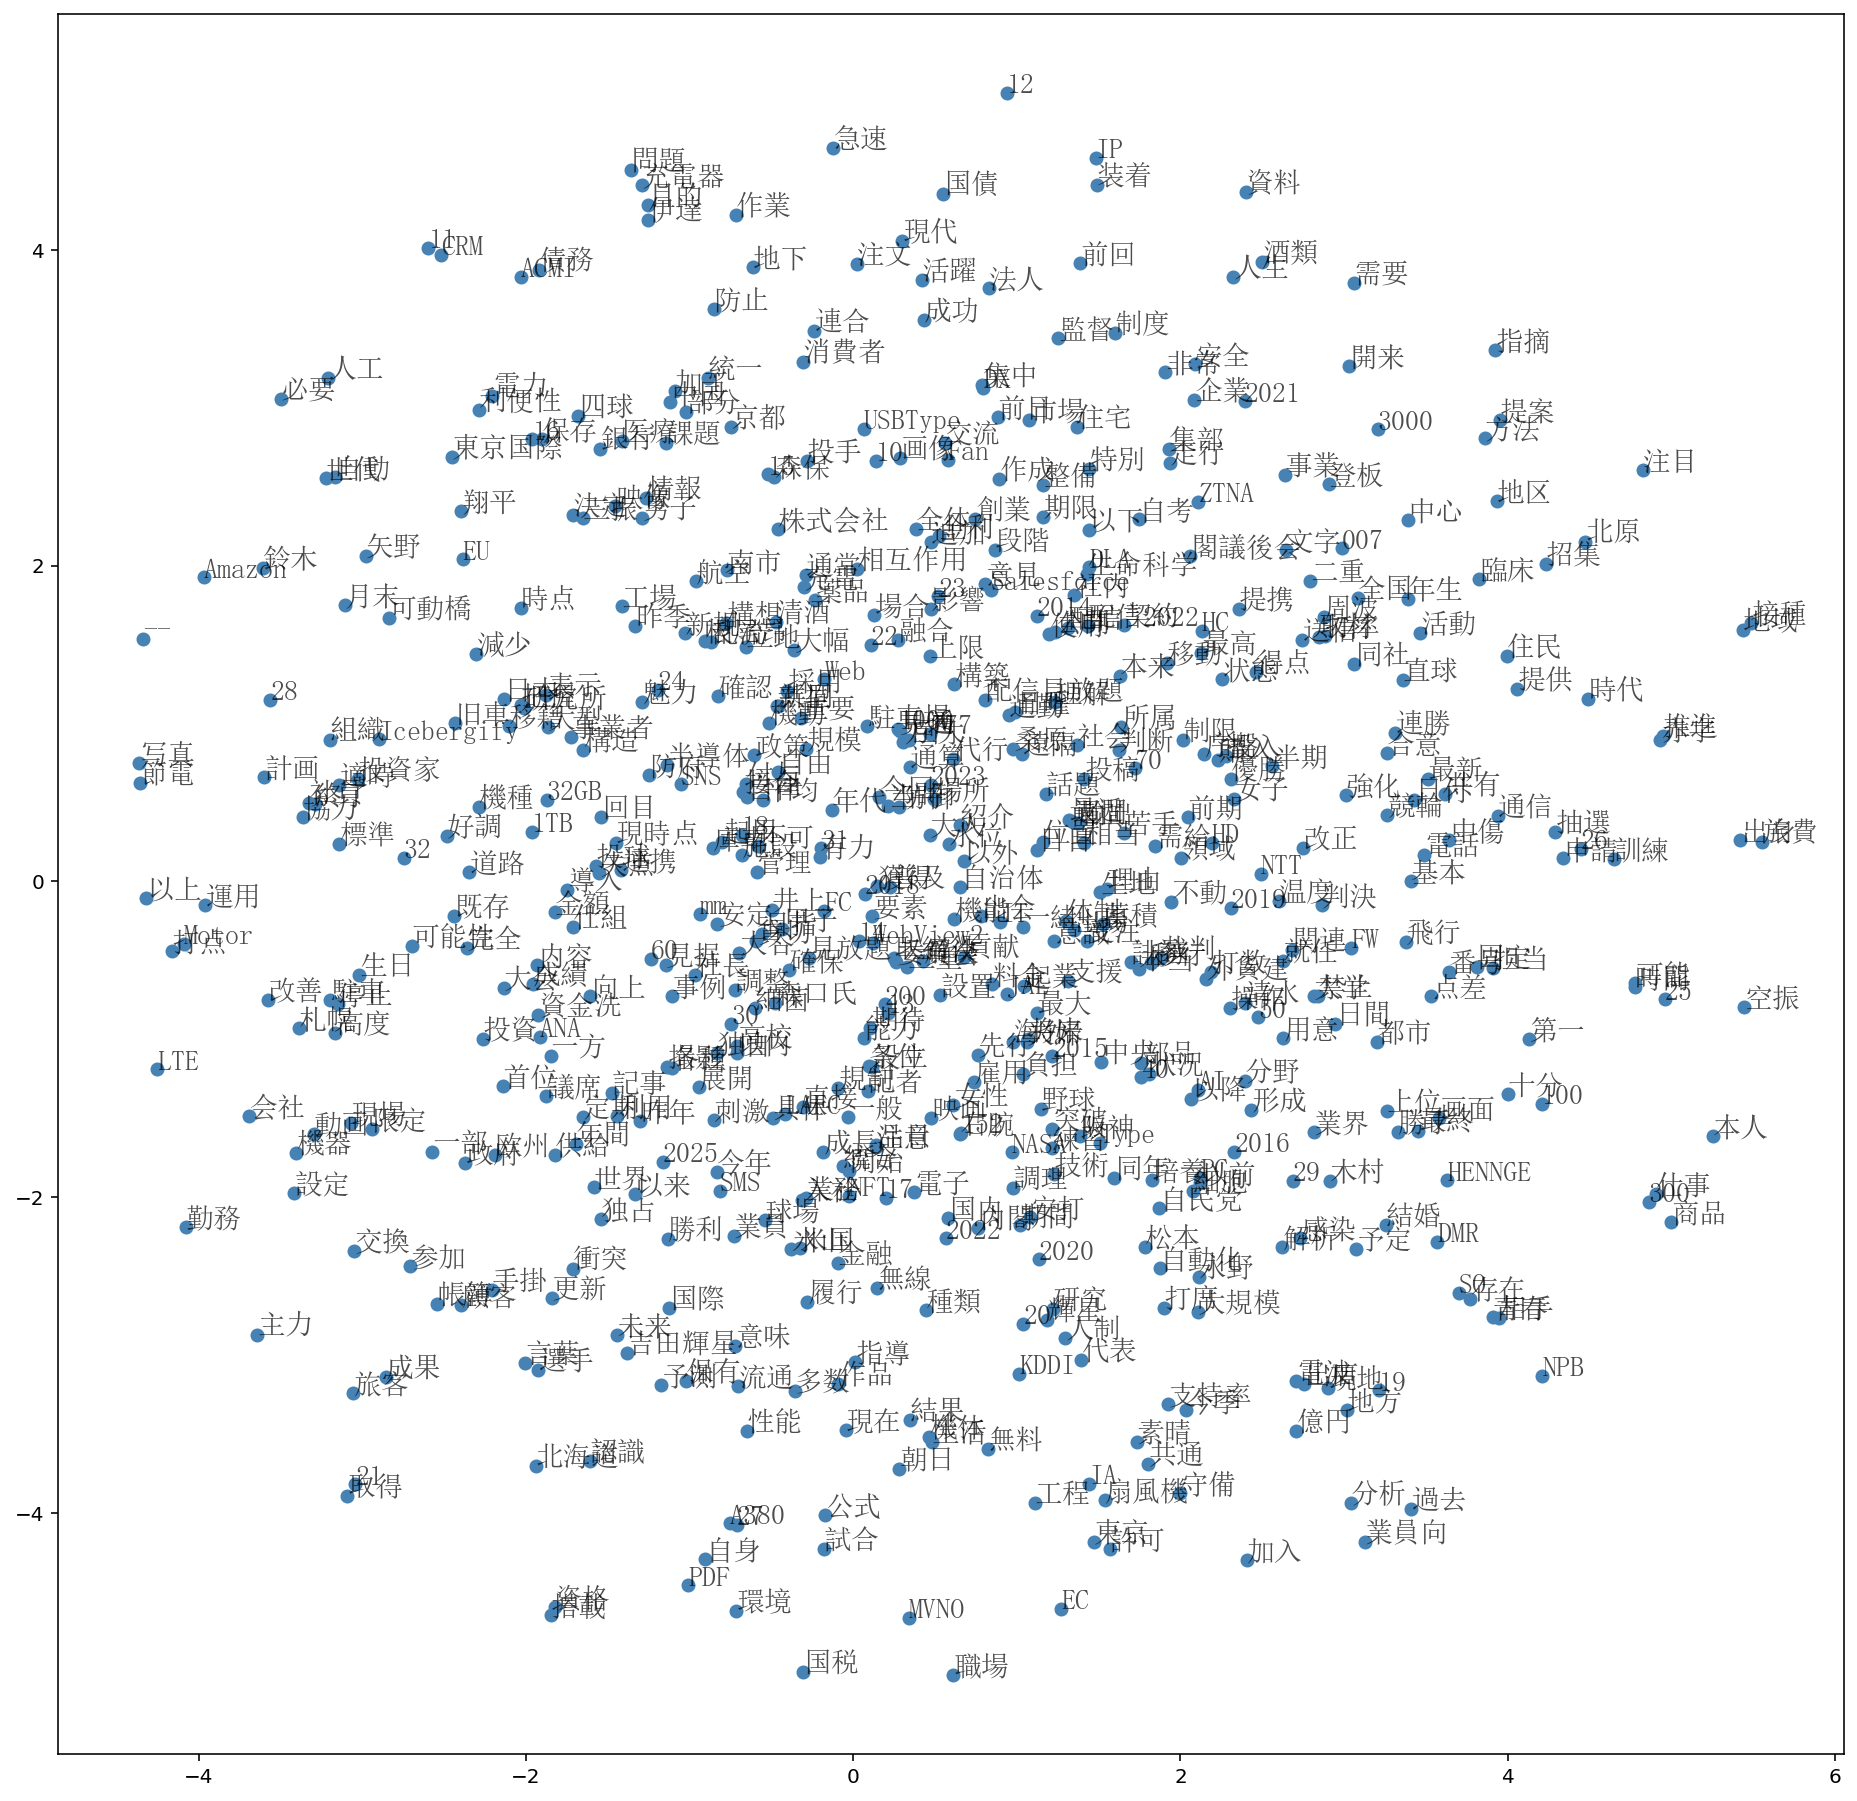

In [19]:
from matplotlib.font_manager import FontProperties
fp = FontProperties(fname=r'simsun.ttc', size=14)

fig, ax = plt.subplots(figsize=(16, 16))
for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7 , fontproperties=fp)
    

In [30]:
valid_examples, valid_similarities = cosine_similarity(model.embed, device=device)
_, closest_idxs = valid_similarities.topk(6) # topk highest similarities

valid_examples, closest_idxs = valid_examples.to('cpu'), closest_idxs.to('cpu')
for ii, valid_idx in enumerate(valid_examples):
    closest_words = [int_to_vocab[idx.item()] for idx in closest_idxs[ii]][1:]
    print(int_to_vocab[valid_idx.item()] + " | " + ', '.join(closest_words))
print("...")

作品 | 優賞, 今週, 本格化, 獲得根尾昂, 作品洋画
地域 | 接種, 需要伊丹, 門家, 入国, 北米
高校 | 日米, 新聞社獲得USATODAYSports通算, 陛下, 会見, 設定設定
札幌 | 予定洋画2022見放題, 停止, 育成, 会社, 小沼佐藤
大谷 | 数十年, 優勝GonzaloFuentes独立, TYPE2地域, 達成独立, 作井春愛
課題 | 役所, 編集ZETA, 中国, 混乱, 才能
2022 | 法令, 2.90, 語手, X2700H, 大阪府
影響 | 可能操作, 任者, PCWatch, Sub6, 上限
格納庫 | S21630HT, 出品, 素敵玉西武, 依存性, 径制
見方 | 起点, 世紀, 44, 2W101392B, 肉眼
富裕 | 辻村, 1.6, 施策, SalesforceFinancialServicesCloud, 15kg
直前 | 分間材料, 名付, 水準, 思惑, 直球
常識 | 金足, 推移, 格差, EXPO, 仕留球数
抗体 | 日時点, 機確, 施策, mobile利用, 確保
慣習 | 仕留球数, 予約, 金利, 真逆, 始末社会
展示 | 京都, 山口, 海野千葉12大竹椎野福岡, 土地SHOPSTOP, 指差相手
...
